<a href="https://colab.research.google.com/github/ShreyasJothish/DS-Unit-2-Sprint-1-Linear-Algebra/blob/master/module4-clustering/Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

Your assignment is to use the TMDB 5000 dataset from Kaggle to try and cluster similar movies. 

It may be helpful to use PCA to reduce the dimensions of your data first - but then again maybe not. I dunno, you're the data scientist, you tell me. 🤪 

I'll let you download the dataset and get it into your notebook in the way that works best for you:

<https://www.kaggle.com/tmdb/tmdb-movie-metadata/version/2>

There are a few weird data cleaning steps that you'll need to do that I don't want you to get stuck on or spend a lot of time on so I'll try and help you out a little bit. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/tmdb_5000_movies.csv")
print(df.shape)
df.head(1).T

(4803, 20)


,0
budget,237000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/
id,19995
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":..."
original_language,en
original_title,Avatar
overview,"In the 22nd century, a paraplegic Marine is di..."
popularity,150.438
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289..."


In [0]:
# There's probably some pandas function that will do this but...
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in df.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df.columns.difference(str_list)  

In [0]:
# Filter the dataframe by only the numeric columns
df_numeric = df[num_list]

In [4]:
# lazily fill NaNs with zeros
df_numeric = df_numeric.fillna(value=0, axis=1)
#df_numeric.drop('id', axis=1, inplace=True)
df_numeric.head(1)

,budget,id,popularity,revenue,runtime,vote_average,vote_count
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800


# You take it from here!

See what you can come up with. You have all the know-how! 

In [5]:
# KMeans without dimension reduction.

from sklearn.cluster import KMeans
import numpy as np

kmeans_val = KMeans(n_clusters=3, random_state=0).fit(df_numeric)
print("labels:\n", kmeans_val.labels_)
print("cluster centers:\n", kmeans_val.cluster_centers_)

print("cluster inertia:\n", kmeans_val.inertia_)




labels:
 [1 1 1 ... 0 0 0]
cluster centers:
 [[1.72154211e+07 5.94812609e+04 1.42926286e+01 2.70776392e+07
  1.04709897e+02 6.00815915e+00 3.54909595e+02]
 [1.49676493e+08 6.21465821e+04 1.10824122e+02 8.09162585e+08
  1.26731343e+02 6.89253731e+00 4.96933582e+03]
 [7.31865896e+07 4.30345158e+04 4.53023773e+01 2.56654378e+08
  1.15080229e+02 6.41647564e+00 1.77633238e+03]]
cluster inertia:
 2.7333769137585127e+19


In [0]:
from sklearn.metrics import silhouette_score

sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_numeric)
    sum_of_squared_distances.append(km.inertia_)
    

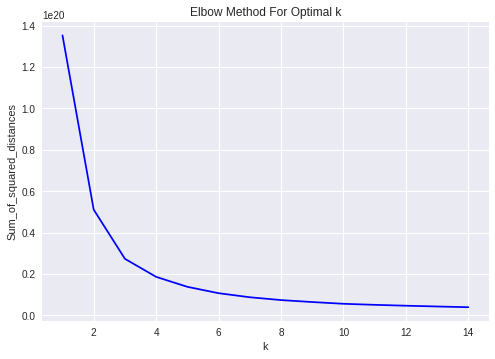

In [7]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [8]:
# KMeans without dimension reduction based on elbow method

from sklearn.cluster import KMeans
import numpy as np

kmeans_val = KMeans(n_clusters=3, random_state=0).fit(df_numeric)
print("labels:\n", kmeans_val.labels_)
print("cluster centers:\n", kmeans_val.cluster_centers_)
print("cluster inertia:\n", kmeans_val.inertia_)

labels:
 [1 1 1 ... 0 0 0]
cluster centers:
 [[1.72154211e+07 5.94812609e+04 1.42926286e+01 2.70776392e+07
  1.04709897e+02 6.00815915e+00 3.54909595e+02]
 [1.49676493e+08 6.21465821e+04 1.10824122e+02 8.09162585e+08
  1.26731343e+02 6.89253731e+00 4.96933582e+03]
 [7.31865896e+07 4.30345158e+04 4.53023773e+01 2.56654378e+08
  1.15080229e+02 6.41647564e+00 1.77633238e+03]]
cluster inertia:
 2.7333769137585127e+19



 Eigenvectors: 
 [[ 0.42955888 -0.06779967  0.45577203  0.48744498  0.25254313  0.23292115
   0.49751516]
 [ 0.15819614  0.60459644  0.15529443  0.17519204 -0.45149207 -0.5775
   0.13144268]]

 Eigenvalues: 
 [3.27639513 1.34750731]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


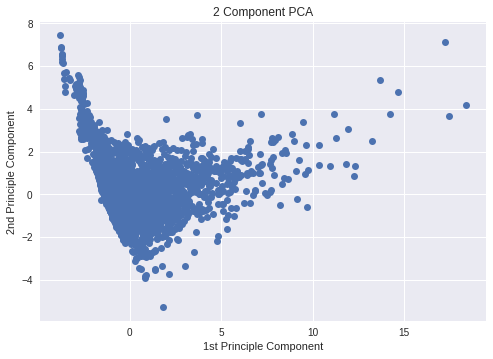

In [9]:
# KMeans with dimension reduction using PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df_pca = StandardScaler().fit_transform(df_numeric)
# create the PCA instance
pca = PCA(2)
# fit on data
pca.fit(df_pca)
# access values and vectors
print("\n Eigenvectors: \n", pca.components_)
print("\n Eigenvalues: \n",pca.explained_variance_)
# transform data
T = pca.transform(df_pca)
#print("\n Projected Data: \n", T)

xx, xy = T.T
plt.plot(xx,xy,'o')
plt.xlabel("1st Principle Component")
plt.ylabel("2nd Principle Component")
plt.title("2 Component PCA")
plt.show()

In [10]:
df2 = pd.DataFrame(T, columns=['PC1', 'PC2'])
df3 = pd.DataFrame(kmeans_val.labels_, columns=['label'])
df4 = df2.join(df3)
df4.head()

,PC1,PC2,label
0,17.475848,3.645451,1
1,9.601307,0.963457,1
2,7.804410,2.619383,1
3,10.972392,1.335680,1
4,4.227285,0.820444,2


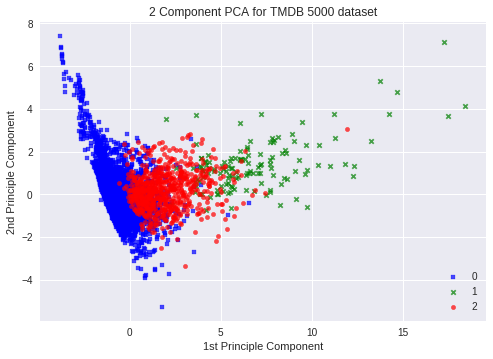

In [11]:
import matplotlib.pyplot as plt
from mlxtend.plotting import category_scatter

fig = category_scatter(x='PC1', y='PC2', label_col='label', 
                       data=df4, legend_loc='lower right')

plt.xlabel("1st Principle Component")
plt.ylabel("2nd Principle Component")
plt.title("2 Component PCA for TMDB 5000 dataset")
plt.show()

# Stretch Goal:

If you look at the original dataset you'll notice that I threw away some potentially useful columns. See if there are any that you could clean more effectively and turn into a numeric representation (probably some kind of one-hot-encoding of categorical variables) to assist your clustering. There's a lot more work here than the hours we have today however, so don't kill yourself trying to incorporate every single column from the original dataset, just take it one column at a time.

**Side Note** Data Science is never DONE. You just reach a point where the cost isn't worth the benefit anymore. There's always more moderate to small improvements that we could make. Don't be a perfectionist, be a pragmatist.